In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../../..'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k

In [2]:
# Create and start the root class
root = epix_hr_single_10k.Root(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_1',
    asicVersion = 4,
    pollEn      = False
)
root.start()

Simulation mode : False
justCtrl mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
root.Core.AxiVersion.FpgaReload()
time.sleep(5)

In [4]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 0:00:02
GitHash      = 0x3905201d425f6a817c3e52f94722916517917dde
XilinxDnaId  = 0x40020001016011410501c185
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv408 (CentOS Linux 7 (Core))
BuildDate    = Sun Nov 24 22:10:40 PST 2024
Builder      = ddoering
###################################################


In [5]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
root.EpixHR.InitASIC([4,1,1,1,1])
#points to the ASIC device under test
root.EpixHR.PacketRegisters0.asicDataReq.set(145)
root.EpixHR.PacketRegisters1.asicDataReq.set(145)
root.EpixHR.PacketRegisters0.DisableLane.set(0xfff)
root.EpixHR.PacketRegisters0.EnumerateDisLane.set(0)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_RegisterControl_24us_248MHz.yml
Loading packet registers
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/pre-proc/../../../yml/ePixHr10kT_PLLBypass_248MHz_ASIC_0.yml
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic0.ClearMatrix
Loading  /u1/d

In [8]:
# Runs triggers for 3 seconds to aquire data, no corrections at this point
root.EpixHR.TriggerRegisters.enable.set(True)
root.EpixHR.TriggerRegisters.SetAutoTrigger(4)
root.EpixHR.TriggerRegisters.StartAutoTrigger()
time.sleep(3)
root.EpixHR.TriggerRegisters.StopTriggers()

Set Auto Trigger command executed
Start Auto Trigger command executed
Stop Triggers command executed


In [9]:
root.EpixHR.TriggerRegisters.StopTriggers()

Stop Triggers command executed


20
(144, 384)


[]

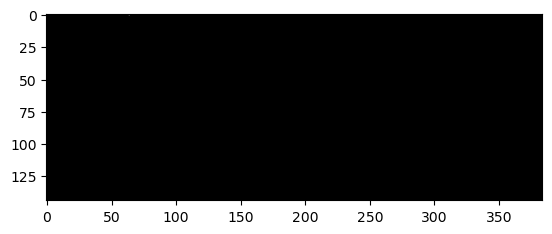

In [10]:
# Confirms that the detector is sending zeros
print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=20)
plt.plot()

In [11]:
#Sets the calibration parameters with dark high only
imgRows = 145
imgCols = 384
darkHigh = np.ones((imgRows,imgCols),dtype=np.uint64)*00
darkHigh[:, 10] = np.arange(imgRows)
darkHigh[:,300] = np.arange(imgRows)
darkHigh[0, :] = np.arange(384)
darkHigh[10, :] = np.arange(384)
darkHigh[100, :] = np.arange(384)
darkHigh[110, :] = np.arange(384)
gainHigh = np.ones((imgRows,imgCols),dtype=np.uint64)*0
darkLow  = np.ones((imgRows,imgCols),dtype=np.uint64)*0
gainLow  = np.ones((imgRows,imgCols),dtype=np.uint64)*0

calibParams = root.dummyGen0.setCalibArray(gainLow,darkLow,gainHigh,darkHigh)
root.dummyGen0.testImage = calibParams

In [12]:
# Downloads the calibration parameters & set the correction to perform dark subtraction only
root.EpixHR.TriggerRegisters.StopTriggers()
#HLS
root.EpixHR.DataCorrectionHLS.enable.set(True)
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(1)
root.dummyGen0.SendCalibFrame()
time.sleep(1)
print(root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get())
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(2)
print(root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get())

Stop Triggers command executed
ibFrame.getPayload() = 445440
1
2


In [13]:
# Runs triggers for 3 seconds to acquire data: dark subtracted images
# since incoming images are zero the net effect is negative images
root.EpixHR.TriggerRegisters.SetAutoTrigger(4)
root.EpixHR.TriggerRegisters.StartAutoTrigger()
time.sleep(3)
root.EpixHR.TriggerRegisters.StopTriggers()

Set Auto Trigger command executed
Start Auto Trigger command executed
Stop Triggers command executed


30
(144, 384)
(144, 384)


[]

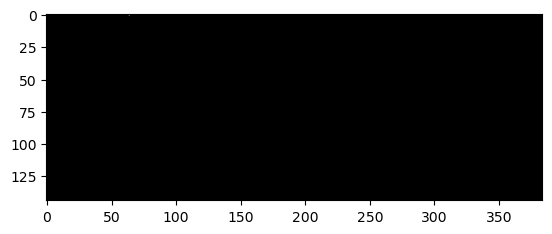

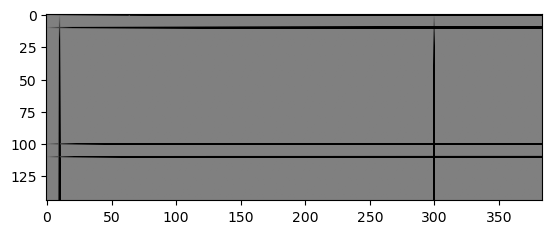

In [14]:
# dark subtracted images
# since incoming images are zero the net effect is negative images
print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=20)
plt.plot()

plt.figure()
pre = root.DataReceiver2.Data.get().astype(np.int16)
print(pre.shape)
dark.shape
plt.imshow(pre, cmap='gray', vmin=-40, vmax=40)
plt.plot()
#print(pre[0,:])
#print(pre[72,:])
#print(pre[:,10])

In [15]:
# Requesting one ASIC data and keeping the second masked but now bank IDs are included
root.EpixHR.PacketRegisters0.DisableLane.set(0xFC0)
root.EpixHR.PacketRegisters0.EnumerateDisLane.set(0xFFF)

In [18]:
# Runs triggers for 3 seconds to acquire data: dark subtracted images
root.EpixHR.TriggerRegisters.SetAutoTrigger(4)
root.EpixHR.TriggerRegisters.StartAutoTrigger()
time.sleep(3)
root.EpixHR.TriggerRegisters.StopTriggers()

Set Auto Trigger command executed
Start Auto Trigger command executed
Stop Triggers command executed


60
(144, 384)


[]

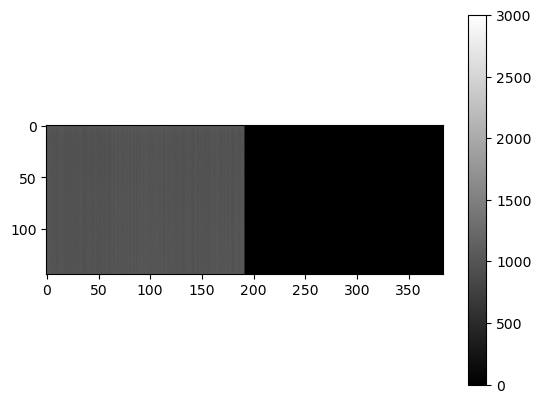

In [19]:
# print raw data (remember that pre-process data is sent on lane 2)
# save a single frame of raw data as dark image
print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=3000)
plt.colorbar()
plt.plot()

In [20]:
# generates calib parameters using raw data (dark image) to the corrector
imgRows = 145
imgCols = 384
darkHigh = np.ones((imgRows,imgCols),dtype=np.uint64)*0
darkHigh[0:144,:] = dark.astype(np.uint64)-100
gainHigh = np.ones((imgRows,imgCols),dtype=np.uint64)*0
darkLow  = np.ones((imgRows,imgCols),dtype=np.uint64)*0
gainLow  = np.ones((imgRows,imgCols),dtype=np.uint64)*0

calibParams = root.dummyGen0.setCalibArray(gainLow,darkLow,gainHigh,darkHigh)
root.dummyGen0.testImage = calibParams

In [21]:
# downloads raw data (dark image) to the corrector
root.EpixHR.TriggerRegisters.StopTriggers()
#HLS
root.EpixHR.DataCorrectionHLS.enable.set(True)
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(1)
root.dummyGen0.SendCalibFrame()
time.sleep(1)
print(root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get())
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(2)
print(root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get())

Stop Triggers command executed
ibFrame.getPayload() = 445440
1
2


In [22]:
# Acquires 3 seconds of data
root.EpixHR.TriggerRegisters.SetAutoTrigger(4)
root.EpixHR.TriggerRegisters.StartAutoTrigger()
time.sleep(3)
root.EpixHR.TriggerRegisters.StopTriggers()

Set Auto Trigger command executed
Start Auto Trigger command executed
Stop Triggers command executed


70
(144, 384)
(144, 384)


[]

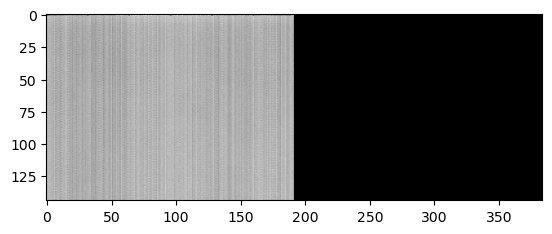

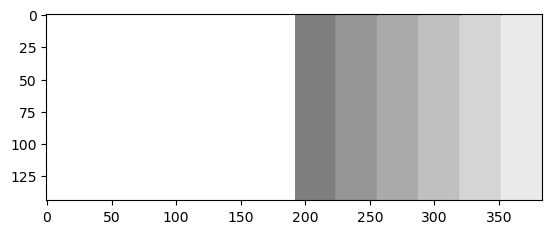

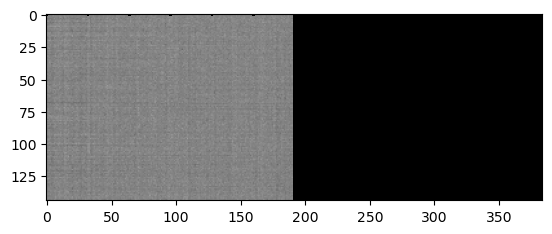

In [23]:
# plot raw data using two contrasts to show bank ID on the right side and dark subtracted data
print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=500, vmax=1200)
plt.plot()
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=12)
plt.plot()

plt.figure()
pre = root.DataReceiver2.Data.get().astype(np.int16)
print(pre.shape)
dark.shape
plt.imshow(pre, cmap='gray', vmin=100, vmax=300)
plt.plot()
#print(pre[0,:])
#print(pre[72,:])
#print(pre[:,10])

In [33]:
# ASCII art (text to calib parameters)
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def text_phantom(text, height, width):
    # Availability is platform dependent
    #font = 'arial'
    
    # Create font
    #pil_font = ImageFont.truetype(font + ".ttf", size=size // len(text),
    #                              encoding="unic")
    #text_width, text_height = pil_font.getsize(text)

    text_width, text_height = [80,360]

    # create a blank canvas with extra space between lines
    canvas = Image.new('RGB', [width, height], (255, 255, 255))

    # draw the text onto the canvas
    draw = ImageDraw.Draw(canvas)
    offset = ((height - text_width) // 2,
              (width - text_height) // 2)
    white = "#000000"
    draw.text(offset, text, fill=white)

    # Convert the canvas into an array with values in [0, 1]
    return (255 - np.asarray(canvas)) / 255.0

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


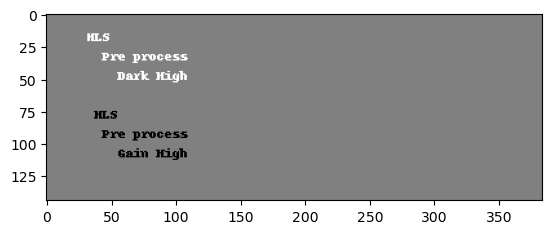

In [125]:
# generates dark and gain calib parameters
map_darkHigh = (text_phantom('HLS\n  Pre process\n    Dark High', 144, 384)[:,:,0]).astype(np.uint16)
map_gainHigh = 1-(text_phantom('\n\n\n\n HLS\n  Pre process\n    Gain High', 144, 384)[:,:,0]).astype(np.uint16)
plt.imshow(map_darkHigh)
plt.imshow(map_gainHigh)
plt.imshow(map_darkHigh+map_gainHigh, cmap='gray')
print(map_gainHigh)

In [100]:
# mask all channels again
root.EpixHR.PacketRegisters0.DisableLane.set(0xFFF)
root.EpixHR.PacketRegisters0.EnumerateDisLane.set(0xFFF)

In [101]:
# generates calib maps from the ascii art
imgRows = 145
imgCols = 384
darkHigh = np.ones((imgRows,imgCols),dtype=np.uint64)*0
darkHigh[0:144,:] = map_darkHigh.astype(np.uint64)*50+50
gainHigh = np.ones((imgRows,imgCols),dtype=np.uint64)*0
gainHigh[0:144,:] = map_gainHigh.astype(np.uint64)*128
darkLow  = np.ones((imgRows,imgCols),dtype=np.uint64)*0
gainLow  = np.ones((imgRows,imgCols),dtype=np.uint64)*0

calibParams = root.dummyGen0.setCalibArray(gainLow,darkLow,gainHigh,darkHigh)
root.dummyGen0.testImage = calibParams

In [102]:
# downloads calib parameters
root.EpixHR.TriggerRegisters.StopTriggers()
#HLS
root.EpixHR.DataCorrectionHLS.enable.set(True)
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(1)
root.dummyGen0.SendCalibFrame()
time.sleep(1)
print(root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get())
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(2)
print(root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.get())

Stop Triggers command executed
ibFrame.getPayload() = 445440
1
2


In [103]:
#Take 3 seconds of data
root.EpixHR.TriggerRegisters.SetAutoTrigger(4)
root.EpixHR.TriggerRegisters.StartAutoTrigger()
time.sleep(3)
root.EpixHR.TriggerRegisters.StopTriggers()

Set Auto Trigger command executed
Start Auto Trigger command executed
Stop Triggers command executed


300
(144, 384)
(144, 384)


[]

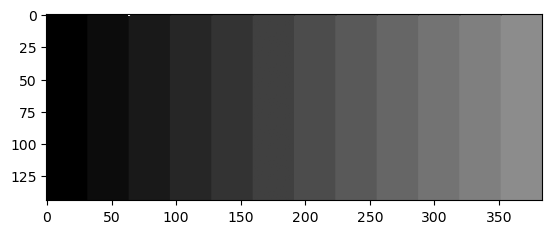

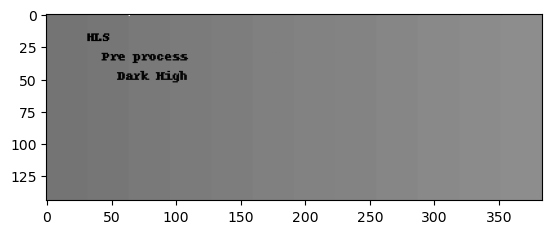

In [109]:
# plot raw and dark subtracted images
print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=20)
plt.plot()

plt.figure()
pre = root.DataReceiver2.Data.get().astype(np.int16)
print(dark.shape)
dark.shape
plt.imshow(pre, cmap='gray', vmin=-200, vmax=20)
plt.plot()

In [114]:
# select gain correction only (should normally not be allowed)
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(4)

In [118]:
# takes 3 seconds of data
root.EpixHR.TriggerRegisters.SetAutoTrigger(4)
root.EpixHR.TriggerRegisters.StartAutoTrigger()
time.sleep(3)
root.EpixHR.TriggerRegisters.StopTriggers()

Set Auto Trigger command executed
Start Auto Trigger command executed
Stop Triggers command executed


350
(144, 384)
(144, 384)


[]

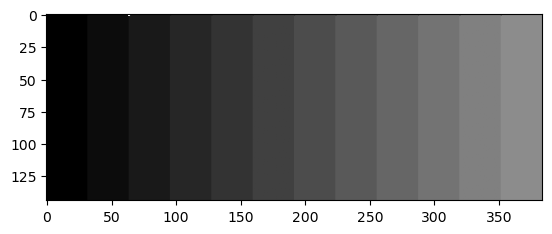

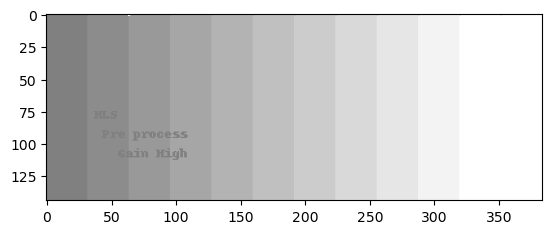

In [120]:
# plots raw and gain corrected images

print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=20)
plt.plot()

plt.figure()
pre = root.DataReceiver2.Data.get().astype(np.int16)
print(dark.shape)
dark.shape
plt.imshow(pre, cmap='gray', vmin=-20, vmax=20)
plt.plot()

In [121]:
#select dark subtracted and gain corrections
root.EpixHR.DataCorrectionHLS.HLSAxiLileReg.set(6)

In [123]:
# takes 3 seconds of data
root.EpixHR.TriggerRegisters.SetAutoTrigger(4)
root.EpixHR.TriggerRegisters.StartAutoTrigger()
time.sleep(3)
root.EpixHR.TriggerRegisters.StopTriggers()

Set Auto Trigger command executed
Start Auto Trigger command executed
Stop Triggers command executed


370
(144, 384)
(144, 384)


[]

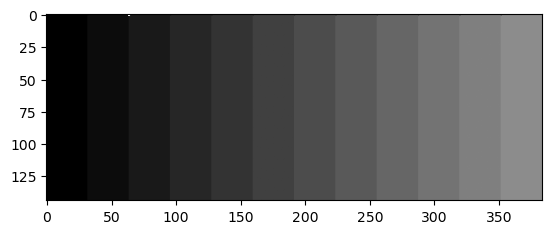

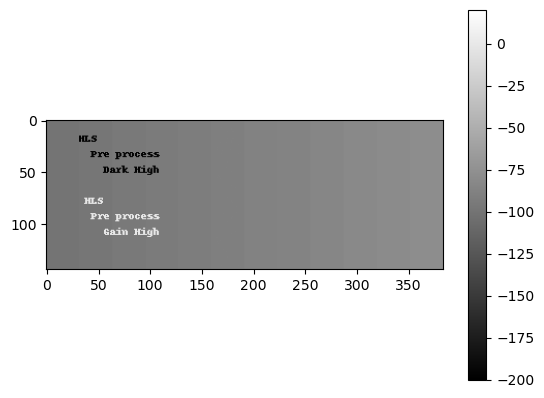

In [126]:
# plot dark and corrected image
print(root.DataReceiver0.FrameCount.get())
dark = root.DataReceiver0.Data.get()
print(dark.shape)
plt.figure()
plt.imshow(dark, cmap='gray', vmin=0, vmax=20)
plt.plot()

plt.figure()
pre = root.DataReceiver2.Data.get().astype(np.int16)
print(dark.shape)
dark.shape
plt.imshow(pre, cmap='gray', vmin=-200, vmax=20)
plt.colorbar()
plt.plot()

# Helper functions

In [ ]:
import struct
result = np.zeros((imgRows,imgCols),dtype=np.uint64)
for i in range(145):
    for j in range (384):
        result[i,j] = struct.unpack('<Q', root.dummyGen1._fullData[16+(i*384*8+j*8):24+(i*384*8+j*8)])[0]
print(result.astype(np.uint16)[0,:])
plt.figure()
plt.imshow(result, cmap='gray', vmin=-40, vmax=40)
plt.plot()

In [ ]:
def run_asic_test():
    if os.path.isfile(f'{filename}'):   
        os.remove(f'{filename}')    
    print(filename)
    # Setup and open the file writer
    writer = root.dataWriter._writer
    writer.open(f'{filename}')

    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0)    

    #sets TriggerRegisters
    AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(50000) #in steps of 10ns
    root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    #wait for the camera to get thermally stable
    time.sleep(5.0)    
    root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
    root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
    initialFrameCounter = writer.getFrameCount()
    # Wait for the file write noise data
    while(writer.getFrameCount() < initialFrameCounter + 4000):
        print( f'Number of frames received: {writer.getFrameCount()}' )
        time.sleep(1)

    # stops triggers
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    # Print the status
    DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
    #print( f'Delta Aquisition Counter: {DeltaAcqCount}')
    print( f'Number of frames received: {writer.getFrameCount()}' )

    # Close the file writer
    writer.close()

    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)

    ########################################################################################################################3
    f = open(filename, mode = 'rb')
    imgDesc = []
    for i in range(1):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,16)
        imgDesc2 = currentCam.getDescImaData(allFrames)
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        if i == 1: #skips the first dataset
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    numberOfFrames = allFrames.shape[0]
    print(allFrames.shape)
    ###########################################################################################################################
    return imgDesc


In [ ]:
def noise_print(offset = 0):
    print(imgDesc[100].shape)
    hg_n  = imgDesc[:,:,offset:offset+192].astype('float64')
    hg_n -= np.median(hg_n, axis=0, keepdims=True)
    hg_n -= np.median(hg_n, axis=(1,2), keepdims=True)
    hg_n -= np.median(hg_n, axis=2, keepdims=True) # rows (cols)
    hg_n -= np.median(hg_n, axis=1, keepdims=True) # cols (rows)
    imgDescCMC = hg_n
    noiseMap = np.std(imgDescCMC,0)
    darkAvg  = np.mean(imgDesc,0)
    
    #noiseMap = np.std(imgDesc[:,:,offset:offset+192],0)
    #darkAvg  = np.mean(imgDesc[:,:,192:384],0)
    medianNoise = np.median(noiseMap)
    plt.figure(1,figsize=(12,8),dpi=150)
    plt.imshow(noiseMap, cmap='gray', vmin=0, vmax=100)
    plt.colorbar(location='right', anchor=(0, 0.3), shrink=0.7)

    plt.figure(2,figsize=(12,8),dpi=150)
    dataset = noiseMap
    plt.hist(dataset.reshape(-1), bins=100, label=f'\nNoise Map distribution AHL, Avg. Dark level w/o CMC %d, Mediam Noise %d' % (np.mean(np.mean(darkAvg)), medianNoise)) 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    print()
    return noiseMap, darkAvg

# Pixel Optimizaion

In [ ]:
def setPixel (Preamp = 4, Vld1_b = 1, Pixel_CB = 4, Filter_DAC = 38, VRef_DAC = 53):
    ASIC.Preamp.set(Preamp)
    ASIC.Vld1_b.set(Vld1_b)
    ASIC.Pixel_CB.set(Pixel_CB)
    ASIC.Filter_DAC.set(Filter_DAC)
    ASIC.VRef_DAC.set(VRef_DAC)


    print('Preamp', ASIC.Preamp.get())
    print('Vld1_b',ASIC.Vld1_b.get())
    print('Pixel_CB',ASIC.Pixel_CB.get())
    print('Filter_DAC',ASIC.Filter_DAC.get())
    print('VRef_DAC',ASIC.VRef_DAC.get())

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [7,6,5,4,3,2,1,0]
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58

for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_bList = [0, 1, 2, 3]
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58

for Vld1_b in Vld1_bList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_b = 0
Pixel_CBList= [7,6,5,4,3,2,1,0]
Filter_DAC= 17
VRef_DAC = 58

for Pixel_CB in Pixel_CBList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_b = 0
Pixel_CB= 7
Filter_DACList=[7, 13, 15, 17, 19, 21, 27, 37, 47, 57]
VRef_DAC = 58

for Filter_DAC in Filter_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
Preamp = 7
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DACList =[3, 13, 23, 33, 43, 48, 53, 58, 63]

for VRef_DAC in VRef_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

# ADC Optimizaion

In [ ]:
#Set pixels back to default value
ASIC.Preamp.set(4)
ASIC.Vld1_b.set(1)
ASIC.Pixel_CB.set(4)
ASIC.Filter_DAC.set(38)
ASIC.VRef_DAC.set(53)

print('Preamp', ASIC.Preamp.get())
print('Vld1_b',ASIC.Vld1_b.get())
print('Pixel_CB',ASIC.Pixel_CB.get())
print('Filter_DAC',ASIC.Filter_DAC.get())
print('VRef_DAC',ASIC.VRef_DAC.get())

In [ ]:
def setADC (RefGenB = 3, RefGenC = 2, S2D_1_b = 0, shvc_DAC = 23, S2dDacBias = 3):
    ASIC.RefGenB.set(RefGenB) #2 bits
    ASIC.RefGenC.set(RefGenC) #2 bits
    ASIC.S2D_1_b.set(S2D_1_b) #3 bits
    ASIC.shvc_DAC.set(shvc_DAC) #6 bits
    ASIC.S2dDacBias.set(S2dDacBias)
    
    print('RefGenB', ASIC.RefGenB.get())
    print('RefGenC',ASIC.RefGenC.get())
    print('S2D_1_b',ASIC.S2D_1_b.get())
    print('shvc_DAC',ASIC.shvc_DAC.get())
    print('S2dDacBias',ASIC.S2dDacBias.get())

In [ ]:
RefGenBList = [0, 1, 2, 3]
RefGenC = 2
S2D_1_b = 0
shvc_DAC = 23
S2dDacBias = 3
for RefGenB in RefGenBList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_RefGenB_%d_All_run1.dat' % RefGenB)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()



In [ ]:
RefGenB = 3
RefGenCList = [0, 1, 2, 3]
S2D_1_b = 0
shvc_DAC = 23
S2dDacBias = 3
for RefGenC in RefGenCList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_RefGenC_%d_All_run1.dat' % RefGenC)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()


In [ ]:
RefGenB = 3
RefGenC = 2
S2D_1_bList = [0, 1, 2, 3, 4, 5, 6, 7]
shvc_DAC = 23
S2dDacBias = 3
for S2D_1_b in S2D_1_bList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_S2D_1_b_%d_All_run1.dat' % S2D_1_b)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DACList = [3, 13, 23, 33, 43, 53, 63]
S2dDacBias = 3
for shvc_DAC in shvc_DACList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_shvc_DAC_%d_All_run1.dat' % shvc_DAC)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DAC = 23
S2dDacBiasList = [0, 1, 2, 3, 4, 5, 6, 7]
for S2dDacBias in S2dDacBiasList:
    setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_S2dDacBias_%d_All_run1.dat' % S2dDacBias)
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

# Custom settings, repeat latest 10kA

In [ ]:
Preamp = 4
Vld1_b = 1
Pixel_CB= 4
Filter_DAC=17
VRef_DAC =19


setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_10ka_settings_All_run1.dat')
########################################################################################################################
imgDesc = run_asic_test()
########################################################################################################################
[noiseMap, darkAvg] = noise_print()


In [ ]:
Preamp = 6
Vld1_b = 1
Pixel_CB= 4
Filter_DAC=17
VRef_DAC =53


setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_10ka_settings_Preamp_%d_VrefDAC_%d_All_run1.dat' % (Preamp , VRef_DAC))
########################################################################################################################
imgDesc = run_asic_test()
########################################################################################################################
[noiseMap, darkAvg] = noise_print()